In [79]:
# tensorflow_text, tensorflow, matplotlib
import numpy as np

import typing
from typing import Any, Tuple
# Customize types
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
# import preprocess module
import tensorflow_text as tf_text
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [80]:
class ShapeChecker:
    def __init__(self):
        # save every cache
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        if isinstance(names, str):
            names = (names,)

        shape = tf.shape(tensor)
        rank = tf.rank(tensor)

        if rank != len(names):
            raise ValueError(f'Rank mismatch:\n'
                             f'    found {rank}: {shape.numpy()}\n'
                             f'    expected {len(names)}: {names}\n')

        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]

            if broadcast and new_dim == 1:
                continue

            if old_dim is None:
                # if the name is new, save it to the cache
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")


In [81]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent /'spa-eng/spa.txt'
print(path_to_file)


/home/zhousc66/.keras/datasets/spa-eng/spa.txt


In [82]:

def load_data(path):
    text = path.read_text(encoding='utf-8')

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    inp = [inp for targ, inp in pairs]
    targ = [targ for targ, inp in pairs]
    # with open('/home/zhousc66/spa.txt', 'w', encoding='utf-8') as f:
    #     for i in range(len(inp)):
    #         f.write(f"{targ[i]}\t{inp[i]}\n")

    return targ, inp

In [83]:
targ, inp = load_data(path_to_file)
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64
# create a tf.data.Dataset string to wash the data and batch it efficiently
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [84]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break


tf.Tensor(
[b'Tiene muchos celos de su mujer.'
 b'Mi hermana es demasiado peque\xc3\xb1a para ir a la escuela.'
 b'\xc2\xbfQu\xc3\xa9 es aquello?' b'Fue agradable hablar con usted.'
 b'Tom no pod\xc3\xada decidir qu\xc3\xa9 ordenar.'], shape=(5,), dtype=string)

tf.Tensor(
[b"He's very jealous of his wife."
 b'My sister is too young to go to school.' b"What's that there?"
 b'Nice talking with you.' b"Tom couldn't decide what to order."], shape=(5,), dtype=string)


In [85]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [86]:
def tf_lower_and_split_punct(text):
    # 对字符进行切分
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # 保持空格，从a到z，并选择标点符号。
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # 在标点符号周围添加空格。
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # 去空格。
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [87]:
print(example_text.numpy().decode())
# 输出解码结果(德语)
print(tf_lower_and_split_punct(example_text).numpy().decode())
# 对句子进行头尾标注
# 输出结果：
# ¿Todavía está en casa?
# [START] ¿ todavia esta en casa ? [END]

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [88]:
max_vocab_size = 5000

input_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

In [89]:
input_text_processor.adapt(inp)
# this is first 10 words in vocabulary
print(input_text_processor.get_vocabulary()[:10])

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']


In [90]:
output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)
output_text_processor.adapt(targ)
print(output_text_processor.get_vocabulary()[:10])

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']


In [91]:
example_tokens = input_text_processor(example_input_batch)
print(example_tokens[:3, :10])

tf.Tensor(
[[   2   44  205    1    6   25  292    4    3    0]
 [   2   24  280   15  126  644   31   68    8   11]
 [   2   13    5   15 2693   12    3    0    0    0]], shape=(3, 10), dtype=int64)


In [92]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] tiene muchos [UNK] de su mujer . [END]       '

Text(0.5, 1.0, 'Mask')

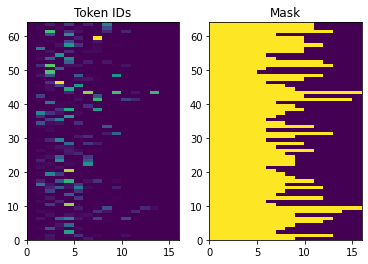

In [93]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')
plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [94]:
#嵌入维度
embedding_dim = 256
#隐藏单元个数
units = 1024

In [95]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size
        # 嵌入层将令牌转换为向量
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                                   embedding_dim)
        # GRU RNN层依次处理这些向量。
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))
        # 嵌入层查找每个标记的嵌入情况。
        vectors = self.embedding(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))
        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))
        # 返回新的序列和它的状态。
        return output, state


In [96]:
# 将输入的文本转换为token。
example_tokens = input_text_processor(example_input_batch)
# 对输入序列进行编码。
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)
print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 16)
Encoder output, shape (batch, s, units): (64, 16, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [97]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)
        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))
        # 构建Query矩阵
        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attn_units'))
        # 构建Key矩阵
        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attn_units'))
        # 构建mask矩阵
        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask
        # 计算得到注意力图谱
        context_vector, attention_weights = self.attention(
            inputs=[w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores=True,
        )
        shape_checker(context_vector, ('batch', 't', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))
        return context_vector, attention_weights

In [98]:
# test attention
# 创建一个BahdanauAttention层
attention_layer = BahdanauAttention(units)
# 后续解码器将产生这个attention查询(Query矩阵)
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])
# 添加到编码tokens
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units): {context_vector.shape}')

print(f'Attention weights shape: (batch_size, query_seq_length,value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units): (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length,value_seq_length): (64, 2, 16)


Text(0.5, 1.0, 'Mask')

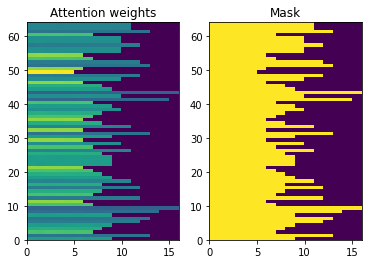

In [99]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')
plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')
# 输出结果：
# Text(0.5, 1.0, 'Mask')

<Figure size 432x288 with 0 Axes>

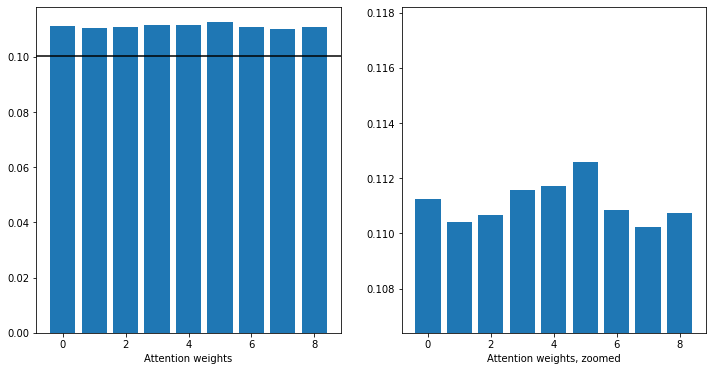

In [100]:
#取出部分attention用于展示
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]
plt.suptitle('Attention weights for one sequence')
plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# 固定x轴
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')
a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')
# 放大结果
top = max(a1.get_ylim())
zoom = 0.85 * top
a2.set_ylim([0.90 * top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')


# 输出结果：
# [<matplotlib.lines.Line2D at 0x20c356a9670>]
# <Figure size 432x288 with 0 Axes>

In [101]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        # 嵌入层将令牌ID转为向量
        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                                   embedding_dim)
        # RNN会记录到目前为止已经生成的内容。
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        # RNN的输出将是注意力层的查询。
        self.attention = BahdanauAttention(self.dec_units)
        self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                        use_bias=False)
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [102]:
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any


class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [103]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
    shape_checker = ShapeChecker()
    shape_checker(inputs.new_tokens, ('batch', 't'))
    shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
    shape_checker(inputs.mask, ('batch', 's'))
    if state is not None:
        shape_checker(state, ('batch', 'dec_units'))
    #查询词嵌入
    vectors = self.embedding(inputs.new_tokens)
    shape_checker(vectors, ('batch', 't', 'embedding_dim'))
    #用RNN处理一个步骤
    rnn_output, state = self.gru(vectors, initial_state=state)
    shape_checker(rnn_output, ('batch', 't', 'dec_units'))
    shape_checker(state, ('batch', 'dec_units'))
    #使用RNN输出作为关注的查询，超过了编码器的输出。

    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
    shape_checker(context_vector, ('batch', 't', 'dec_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))
    # 加入context_vector和rnn_output
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)
    attention_vector = self.Wc(context_and_rnn_output)
    shape_checker(attention_vector, ('batch', 't', 'dec_units'))
    # 生成logit预测
    logits = self.fc(attention_vector)
    shape_checker(logits, ('batch', 't', 'output_vocab_size'))
    return DecoderOutput(logits, attention_weights), state

In [104]:
Decoder.call = call
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [105]:

#转换目标序列，并收集[START]标记。
example_output_tokens = output_text_processor(example_target_batch)
start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [106]:
#运行decoder
dec_result, dec_state = decoder(
    inputs=DecoderInput(new_tokens=first_token,
                        enc_output=example_enc_output,
                        mask=(example_tokens != 0)),
    state=example_enc_state
)
print(f'logits shape: (batch_size, t, output_vocab_size)'
      f'{dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size)(64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


In [107]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
#将令牌解码为输出的第一个单词。
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
print(first_word[:5])

[['release']
 ['understands']
 ['each']
 ['filipino']
 ['neighbor']]


In [108]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
print(first_word[:5])

[['leaks']
 ['harsh']
 ['hes']
 ['restaurant']
 ['ourselves']]


In [109]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):
        shape_checker = ShapeChecker()
        shape_checker(y_true, ('batch', 't'))
        shape_checker(y_pred, ('batch', 't', 'logits'))
        # 计算该批次中每一项的损失。
        loss = self.loss(y_true, y_pred)
        shape_checker(loss, ('batch', 't'))
        # 屏蔽掉填充物上的损失。
        mask = tf.cast(y_true != 0, tf.float32)
        shape_checker(mask, ('batch', 't'))
        loss *= mask
        # 返回总的loss。
        return tf.reduce_sum(loss)

In [110]:
class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units,
                 input_text_processor,
                 output_text_processor,
                 use_tf_function=True):
        super().__init__()

        # 构建编码器和解码器
        encoder = Encoder(input_text_processor.vocabulary_size(),
                          embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(),
                          embedding_dim, units)
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        self.shape_checker = ShapeChecker()

    def train_step(self, inputs):
        self.shape_checker = ShapeChecker()

        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

In [111]:
def _preprocess(self, input_text, target_text):
    self.shape_checker(input_text, ('batch',))
    self.shape_checker(target_text, ('batch',))
    # 将文本转换为tokens ID
    input_tokens = self.input_text_processor(input_text)
    target_tokens = self.output_text_processor(target_text)
    self.shape_checker(input_tokens, ('batch', 's'))
    self.shape_checker(target_tokens, ('batch', 't'))
    # 将ID转换为掩码
    input_mask = input_tokens != 0
    self.shape_checker(input_mask, ('batch', 's'))
    target_mask = target_tokens != 0

    self.shape_checker(target_mask, ('batch', 't'))
    return input_tokens, input_mask, target_tokens, target_mask


TrainTranslator._preprocess = _preprocess

In [112]:
def _train_step(self, inputs):
    input_text, target_text = inputs
    (input_tokens, input_mask,
     target_tokens, target_mask) = self._preprocess(input_text, target_text)
    max_target_length = tf.shape(target_tokens)[1]
    with tf.GradientTape() as tape:
        #对输入进行编码
        enc_output, enc_state = self.encoder(input_tokens)
        self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
        self.shape_checker(enc_state, ('batch', 'enc_units'))
        #将解码器的状态初始化为编码器的最终状态。
        # 这只有在编码器和解码器有相同数量的单位时生效。
        dec_state = enc_state
        loss = tf.constant(0.0)
        for t in tf.range(max_target_length - 1):
            #从目标序列中传入两个token:
            # 1.解码器的当前输入.
            # 2.解码器下次预测的目标.
            new_tokens = target_tokens[:, t:t + 2]
            step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                   enc_output, dec_state)
            loss = loss + step_loss
        #对所有非填充token的损失进行平均计算。
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))
    #设置优化步骤
    variables = self.trainable_variables
    gradients = tape.gradient(average_loss, variables)
    self.optimizer.apply_gradients(zip(gradients, variables))
    # 返回一个映射到当前值的字典
    return {'batch_loss': average_loss}


TrainTranslator._train_step = _train_step

In [113]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
    input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]
    # Run the decoder one step.
    decoder_input = DecoderInput(new_tokens=input_token,
                                 enc_output=enc_output,
                                 mask=input_mask)
    dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
    self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
    self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
    self.shape_checker(dec_state, ('batch', 'dec_units'))
    # `self.loss`返回非填充token的总数。
    y = target_token
    y_pred = dec_result.logits
    step_loss = self.loss(y, y_pred)
    return step_loss, dec_state

In [114]:
TrainTranslator._loop_step = _loop_step

translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)
#配置损失和优化器
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [115]:
np.log(output_text_processor.vocabulary_size())
# 输出结果:
# 8.517193191416238

8.517193191416238

In [116]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print()


# 输出结果:
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6101117>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5797815>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.522971>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.3605533>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.785821>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.0904937>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8641896>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3120656>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.264642>}
# {'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.112561>}

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5950165>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.565028>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.5088153>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.349754>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.805463>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.2475924>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.945118>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.543022>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3282876>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.101766>}

CPU times: user 2min 53s, sys: 42.5 s, total: 3min 35s
Wall time: 13.9 s


In [117]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
    return self._train_step(inputs)


TrainTranslator._tf_train_step = _tf_train_step

translator.use_tf_function = True
#第一次运行由于需要对函数进行追踪，故速度会比较慢
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9866855>}

In [118]:
%%time
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.0140643>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.029606>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9476018>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8669016>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8145373>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.76592>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6985269>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6646805>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6396337>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.587369>}

CPU times: user 2min 53s, sys: 19.3 s, total: 3min 12s
Wall time: 4.32 s


....................................................................................................


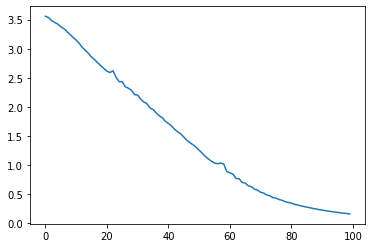

In [119]:
losses = []
for n in range(100):
    print('.', end='')
    logs = translator.train_step([example_input_batch, example_target_batch])
    losses.append(logs['batch_loss'].numpy())
print()
plt.plot(losses)
# 输出结果:
#
# [<matplotlib.lines.Line2D at 0x20c362c3c70>]

In [120]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)
# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [121]:
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])


batch_loss = BatchLogs('batch_loss')

train_translator.fit(dataset, epochs=50,
                     steps_per_epoch=50,
                     callbacks=[batch_loss])

Epoch 1/3
3/3 [==============================] - 9s 526ms/step - batch_loss: 7.5632
Epoch 2/3
3/3 [==============================] - 2s 578ms/step - batch_loss: 6.4422
Epoch 3/3
3/3 [==============================] - 2s 541ms/step - batch_loss: 5.1057


Text(0, 0.5, 'CE/token')

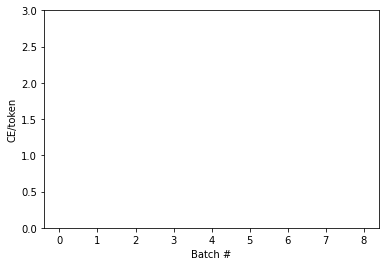

In [122]:
# 如果上一个cell中的epoches和steps_per_epoch过小，此处没有绘图效果。
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [123]:
class Translator(tf.Module):
    def __init__(self, encoder, decoder, input_text_processor,
                 output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.output_token_string_from_index = (
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                mask_token='',
                invert=True))

        # 输出不应该产生padding、unknown或start。
        index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(), mask_token='')
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()
        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)

        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask
        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))


translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [124]:
def tokens_to_text(self, result_tokens):
    shape_checker = ShapeChecker()
    shape_checker(result_tokens, ('batch', 't'))
    result_text_tokens = self.output_token_string_from_index(result_tokens)
    shape_checker(result_text_tokens, ('batch', 't'))
    result_text = tf.strings.reduce_join(result_text_tokens,
                                         axis=1, separator=' ')
    shape_checker(result_text, 'batch')
    result_text = tf.strings.strip(result_text)
    shape_checker(result_text, ('batch',))
    return result_text


Translator.tokens_to_text = tokens_to_text

example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())

translator.tokens_to_text(example_output_tokens).numpy()

array([b'sapporo miles', b'weak arrive', b'spying oath', b'nap march',
       b'exist build'], dtype=object)

In [125]:
def sample(self, logits, temperature):
    shape_checker = ShapeChecker()
    shape_checker(logits, ('batch', 't', 'vocab'))
    shape_checker(self.token_mask, ('vocab',))
    token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
    shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)
    logits = tf.where(self.token_mask, -np.inf, logits)
    if temperature == 0.0:
        new_tokens = tf.argmax(logits, axis=-1)
    else:
        logits = tf.squeeze(logits, axis=1)
        new_tokens = tf.random.categorical(logits / temperature,
                                           num_samples=1)
        shape_checker(new_tokens, ('batch', 't'))
        return new_tokens

Translator.sample = sample

example_logits = tf.random.normal([5, 1,
                                   output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[1360],
       [2479],
       [ 873],
       [1542],
       [ 181]])>

In [126]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
    batch_size = tf.shape(input_text)[0]
    input_tokens = self.input_text_processor(input_text)
    enc_output, enc_state = self.encoder(input_tokens)
    dec_state = enc_state
    new_tokens = tf.fill([batch_size, 1], self.start_token)
    result_tokens = []
    attention = []
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    for _ in range(max_length):
        dec_input = DecoderInput(new_tokens=new_tokens,
                                 enc_output=enc_output,
                                 mask=(input_tokens != 0))
        dec_result, dec_state = self.decoder(dec_input, state=dec_state)
        attention.append(dec_result.attention_weights)
        new_tokens = self.sample(dec_result.logits, temperature)
        done = done | (new_tokens == self.end_token)
        # 一旦一个序列完成，它只产生0-padding。
        new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)
        result_tokens.append(new_tokens)
        if tf.executing_eagerly() and tf.reduce_all(done):
            break
    # 将生成的token id列表转换为字符串列表。

    result_tokens = tf.concat(result_tokens, axis=-1)
    result_text = self.tokens_to_text(result_tokens)
    if return_attention:
        attention_stack = tf.concat(attention, axis=1)
        return {'text': result_text, 'attention': attention_stack}
    else:
        return {'text': result_text}

In [127]:
Translator.translate = translate_unrolled

In [128]:
%%time
input_text = tf.constant([
    'hace mucho frio aqui.',  # "It's freezing here."
    'Esta es mi vida.',  # "This is my life.""
])
result = translator.translate(
    input_text=input_text)

# print(result)
print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()
# 实验结果:
# it is very cold here .
# this is my life .
# Wall time: 266 ms


denied volunteer would happy vacant ignored simpler tidy mary other boy dont gang problems something like have each goats her contest passport the rate french interrupt you came ? relative we that in mary teacher fun . this up we
after asking private reservation sushi count which fairly store ears trees bells shoulder brother are hardly is youre kissing many when born is sorrow i answer long she for lies want ? mahjong is him

CPU times: user 1.91 s, sys: 24.3 ms, total: 1.94 s
Wall time: 1.24 s


In [129]:
from IPython import get_ipython

# 获取当前运行的笔记本
notebook = get_ipython().get_ipython().user_ns['In']

# 打印所有输入单元格的内容
for cell in notebook:
    print(cell)



# tensorflow_text, tensorflow, matplotlib
import numpy as np

import typing
from typing import Any, Tuple
# Customize types
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
# import preprocess module
import tensorflow_text as tf_text
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
class ShapeChecker:
    def __init__(self):
        # save every cache
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        if isinstance(names, str):
            names = (names,)

        shape = tf.shape(tensor)
        rank = tf.rank(tensor)

        if rank != len(names):
            raise ValueError(f'Rank mismatch:\n'
                             f'    found {rank}: {shape.numpy()}\n'
                             f'    expected {len(names)}: {names}\n')

        for i, name in enumerate(names):
            if isinstance(name, int):
                old_